In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import sample
import numba
import time
import copy
from tqdm.notebook import tqdm
plt.rcParams['figure.figsize'] = [8.0, 6.0]
#if using google colab
from google.colab import files
uploaded = files.upload()

Saving liquid256.txt to liquid256.txt


In [2]:
class SpatialDomainData:
  def __init__(self, position=np.array([]), velocity=np.array([]), acceleration=np.array([])):
    self.P = position
    self.V = velocity
    self.A = acceleration

  def __repr__(self):
    return "(P:{}, V:{}, A:{})".format(self.P, self.V, self.A)


  def concat(self, other):
    self.P = np.concatenate((self.P, other.P), 0)
    self.V = np.concatenate((self.V, other.V), 0)
    self.A = np.concatenate((self.A, other.A), 0)


In [3]:
# %%
#Randomlly Initialize the Velocities
@numba.njit
def random_vel_generator(n=256,T_equal=100,m=1,e_scale=1): # n=number of particles
    total_k=3*T_equal*(n-1)/2 #dimensionless
    vel_per_particle=np.zeros((n,3))
    for axis in range(3):
        vel_per_particle[:,axis]=np.random.randn(256,)-0.5
    Mom_x_total=np.sum(vel_per_particle[:,0])
    Mom_y_total=np.sum(vel_per_particle[:,1])
    Mom_z_total=np.sum(vel_per_particle[:,2])
    Mom_x_avg=Mom_x_total/n
    Mom_y_avg=Mom_y_total/n
    Mom_z_avg=Mom_z_total/n
    vel_per_particle=vel_per_particle-np.array([Mom_x_avg,Mom_y_avg,Mom_z_avg]).reshape(1,3)
    k_avg_init=0.5*(1/n)*np.sum(np.sum(vel_per_particle**2,axis=1),axis=0)
    k_avg_T_eq=total_k/n
    scaling_ratio=np.sqrt(k_avg_T_eq/k_avg_init)
    vel_per_particle=vel_per_particle*scaling_ratio
    return vel_per_particle


In [4]:
#function of pbc rule2
@numba.njit
def pbc2(separation,L):
    separation_new=np.zeros((separation.shape[0],3))   
    for i in range(separation.shape[0]):
        separation_ind=separation[i,:]
        separation_empty=np.zeros((1,3))
        for j in range(3):
            separation_axis=numba.float64(separation_ind[j])
            #separation_axis_new=np.zeros((1,))
            if separation_axis < -L/2:
                separation_axis_new=separation_axis+L
            elif separation_axis > L/2:
                separation_axis_new=separation_axis-L
            else:
                separation_axis_new=separation_axis
            separation_empty[:,j]=separation_axis_new
        separation_new[i,:]=separation_empty
    return separation_new

In [5]:
#function of pbc rule1
@numba.njit
def pbc1(position,L):
    x_new=np.zeros((position.shape[0],3))   
    for i in range(position.shape[0]):
        position_ind=position[i,:]
        position_empty=np.zeros((1,3))
        for j in range(3):
            position_axis=numba.float64(position_ind[j])
            #separation_axis_new=np.zeros((1,))
            if position_axis < 0:
                position_axis_new=position_axis+L
            elif position_axis > L:
                position_axis_new=position_axis-L
            else:
                position_axis_new=position_axis
            position_empty[:,j]=position_axis_new
        x_new[i,:]=position_empty
    return x_new

In [6]:
def separate_points(infodict, my_i):
  atoms=256
  neighb_spd=None
  for i,spd in infodict.items():
    if i!=my_i:
      if (neighb_spd is None):
        neighb_spd = copy.deepcopy(spd)
      else:
        neighb_spd.concat(spd)
  #check this
  if my_i>len(infodict):#==100:
    result=0
  else:
    result=infodict[my_i]
  return result,neighb_spd



In [7]:
def concatDict(infodict):
  atoms=256
  wholeDict=None
  for i,spd in infodict.items():
    
      if(wholeDict is None):
        wholeDict = copy.deepcopy(spd)
      else:
        wholeDict.concat(spd)
  
  return wholeDict

In [8]:
# %%
#function of dimensionless LJ: U(r)=4(r^{-12}-r^{-6})
#define the function of acceleration of LJ potential with cut_off

def LJ_accel(position,neighb_x_0,r_cut,L):
    subcube_atoms=position.shape[0]
    #careful kind of confusing
    position=np.concatenate((position,neighb_x_0),0)
    num=position.shape[0]
  
    update_accel=np.zeros((subcube_atoms,3))
    dU_drcut=48*r_cut**(-13)-24*r_cut**(-7) #evaluate at r_cutoff
    #for loop is only of subcube we are interested in but we have to account for ALL distance!
    for atom in range(subcube_atoms):
        position_other=np.concatenate((position[0:atom,:],position[atom+1:num+1,:]),axis=0)
        
        position_atom=position[atom]
        separation=position_atom-position_other   
        separation_new=pbc2(separation=separation,L=L)
        r_relat=np.sqrt(np.sum(separation_new**2,axis=1))
        
        #get out the particles inside the r_cut
        accel=np.zeros((r_relat.shape[0],3))
        #get out the particles inside the r_limit
        for i, r0 in enumerate(r_relat):
            if r0 <= r_cut:
               #active_r_relat.append(r0)
               separation_active_num=separation_new[i,:]
               vector_part=separation_active_num*(1/r0)
               scalar_part=48*r0**(-13)-24*r0**(-7)-dU_drcut
               accel_num=vector_part*scalar_part
               accel[i,:]=accel_num

        update_accel[atom,:]=np.sum(accel,axis=0)
        
    return update_accel.reshape(subcube_atoms,3)

In [9]:
# %%
#Function for avg KE (the system) 
@numba.njit
def Kin_Eng(m,x_dot):
    num=x_dot.shape[0]
    Kinetic_per=0.5*m*np.sum(x_dot**2,axis=1)
    Kinetic_sum=np.sum(Kinetic_per,axis=0)
    return Kinetic_sum

In [10]:
# %%
#Function for avg LJ potential with cut_off
@numba.jit(nopython=True)
def LJ_potent_nondimen(position,r_cut=2.5,L=6.8):
    num=position.shape[0]
    update_LJ=np.zeros((num-1,1))
    
    #fix value for a certain r_limit
    dU_drcut=24*r_cut**(-7)-48*r_cut**(-13)
    U_rcut=4*(r_cut**(-12)-r_cut**(-6))
    #print(numba.typeof(r_cut))
    #L_half=np.array(L/2)
    for ind, atom in enumerate(range(num-1)):
        position_relevent=position[atom:,:]
        position_other=position_relevent[1:,:]
        
        #pbc rule2
        separation=position_relevent[0,:]-position_other
        separation_new=pbc2(separation=separation,L=L)
        
        r_relat=np.sqrt(np.sum(separation_new**2,axis=1)).reshape(separation_new.shape[0],)
        LJ=[]
        #get out the particles inside the r_limit
        for i, r0 in enumerate(r_relat):
            if r0 <= r_cut:
               #active_r_relat.append(r0)
               LJ_num=4*r0**(-12)-4*r0**(-6)-U_rcut-(r0-r_cut)*dU_drcut
               LJ.append(LJ_num)
        #active_particle=r_relat<=r_cut_mat
        #active_r_relat=r_relat[active_particle]
        #active_amount=np.array(active_r_relat).shape[0]
        #if active_amount!=0:
            #LJ=4*active_r_relat**(-12)-4*active_r_relat**(-6)-np.array(U_rcut)-(active_r_relat-r_cut)*np.array(dU_drcut) #double counting issue here
            update_LJ[atom,:]=np.sum(np.array(LJ),axis=0)    
    return np.sum(update_LJ)

In [51]:
# %%
#Function of insta Pressue
@numba.njit
def insta_pressure(L,T,N,position,r_cut,e_scale):
    num=position.shape[0]
    k_B=1.38064852*10**(-23)
    #k_B=1 #if dimensionless
    V=L**3
  
    pres_ideal=N*T*(k_B/e_scale)/V
    dU_drcut=24*r_cut**(-7)-48*r_cut**(-13)
    pres_virial=np.zeros((num-1,1))
    for atom in range(num-1):
        position_relevent=position[atom:,:]
        position_other=position_relevent[1:,:]
        position_atom=position_relevent[0,:]
        
        #pbc rule 2
        separation=position_atom-position_other
        separation_new=pbc2(separation=separation,L=L)
        
        r_relat=np.sqrt(np.sum(separation_new**2,axis=1)).reshape(separation_new.shape[0],)
        force=[]
        active_r_relat=[]
        #get out the particles inside the r_limit
        for i, r0 in enumerate(r_relat):
            if r0 <= r_cut:
               #active_r_relat.append(r0)
               force_num=-(24*r0**(-7)-48*r0**(-13))+dU_drcut
               force.append(force_num)
               active_r_relat.append(r0)    
               
        # #get out the particles inside the r_cut
        active_amount=np.array(active_r_relat).shape[0]
        
        rijFij=np.array(active_r_relat).reshape(1,active_amount)@np.array(force).reshape(active_amount,1)
        pres_virial[atom,:]=rijFij
    pres_insta=pres_ideal+np.sum(pres_virial,axis=0)/(3*V) #Double Count?
    return pres_insta

In [52]:
# %%
#Update rule: velocity Verlet
#@numba.njit
def vel_Ver(infodict,dt,r_limit=2.5,L=6.8):
    proc=len(infodict)
    
    for i in range(1,proc+1):
      ## Get the data for the current spatial domain 
      my_spd, neighs_spd= separate_points(infodict, i)
      #print("mine", my_spd.P.shape)
      #print("other", neighs_spd.P.shape)
      #x_0=my_spd.P
      #x_dot_0=my_spd.V
      #pbc rule 1
      

      #acceleration at 0
      my_spd.A=LJ_accel(position=my_spd.P,neighb_x_0=neighs_spd.P,r_cut=r_limit,L=L)
      
       
      
      #velocity at dt/2
      my_spd.V=my_spd.V+my_spd.A*(dt/2)
      
      #position at dt
      my_spd.P=my_spd.P+my_spd.V*dt
      
      #PBC rule 1
      my_spd.P=pbc1(position=my_spd.P,L=L)
      infodict[i]=my_spd
    
    for i in range(1,proc+1):
      my_spd, neighs_spd= separate_points(infodict, i) 
      
      #acceleration at dt
      my_spd.A=LJ_accel(position=my_spd.P,neighb_x_0=neighs_spd.P,r_cut=r_limit,L=L)
      
      #velocity at dt
      my_spd.V=my_spd.V+my_spd.A*(dt/2)
      infodict[i]=my_spd
    # #collect info
    #info=np.concatenate((x_final,x_dot_final,accel_final),axis=1)
    return infodict #Data shape(N,9) [position_(xyz),velocity_(xyz),force(accel if dimension)_xyz]

In [53]:
# %%
#The LJ potential MD simulation function
#@numba.njit
def LJ_MD(subdiv,position_init,dt,stop_step,accel_init,r_cut,L,T_eq,e_scale,sig):
    #useful constant
    k_B=1.38064852*10**(-23)

    size_sim=position_init.shape[0]
    
    #velocity initialization 
    x_dot_init=random_vel_generator(n=size_sim,T_equal=T_eq,m=1,e_scale=e_scale)
    #print(np.sum(np.sum(x_dot_init**2,1),0))
    #initialize the info matrix
    info=np.zeros((stop_step+1,size_sim,9))
    info[0,:,:]=np.concatenate((position_init,x_dot_init,accel_init),axis=1)
    info_init=info[0,:,:]
    #print(info_init.shape)

    infotodic=celltodic((info[0,:,:]),subdiv[0],subdiv[1],subdiv[2],L)
    
  

#initialize PE, KE, T_insta, P_insta, Momentum
    PE=np.zeros((stop_step+1,1))
    KE=np.zeros((stop_step+1,1))
    T_insta=np.zeros((stop_step+1,1))
    P_insta=np.zeros((stop_step+1,1))
    
    #zero step value
    PE[0,:]=LJ_potent_nondimen(info[0,:,0:3],r_cut=r_cut,L=L)
    
    KE[0,:]=Kin_Eng(m=1,x_dot=info[0,:,3:6])
    #print(KE[0,:])
    T_insta[0,:]=2*KE[0,:]*e_scale/(3*(size_sim-1)*k_B) #k
    P_insta[0,:]=insta_pressure(L=L,T=T_insta[0],N=size_sim,position=info[0,:,0:3],r_cut=r_cut,e_scale=e_scale)#*(e_scale/(L*sig*(10**(-10)))**3) #unitless
    
    step_range=tqdm(list(range(stop_step)))
    #step_range=range(stop_step)

    for step in step_range:#step_range:
          #if step%200==0:
            #print(step)
          #update particles position, velocity, accelerations
          info_temp=vel_Ver(infodict=infotodic,dt=dt,r_limit=r_cut,L=L)
          
          tmp=concatDict(info_temp)
          info[step+1,:,:]=np.concatenate((tmp.P,tmp.V,tmp.A),1)


          #UPDATE CUBES MAKE SURE ATOMS ARE IN RIGHT CUBES
          infotodic=celltodic(info[step+1,:,:],2,2,2,L)

          
          #print(testing[1].A)
          #calculate and store PE, KE, T_insta, P_insta
          PE[step+1,:]=LJ_potent_nondimen(info[step+1,:,0:3],r_cut=r_cut,L=L)
          #print(info[step+1,:,:].shape)
          KE[step+1,:]=Kin_Eng(m=1,x_dot=info[step+1,:,3:6])
          #print(KE[step+1,:])
          #print(PE[step+1,:])
          T_insta[step+1,:]=2*KE[step+1,:]*e_scale/(3*(size_sim-1)*k_B) #k
          P_insta[step+1,:]=insta_pressure(L=L,T=T_insta[step+1],N=size_sim,position=info[step+1,:,0:3],r_cut=r_cut,e_scale=e_scale)#*(e_scale/(L*sig*(10**(-10)))**3) #unitless
    #plt.plot(KE[380,0])
    return info,PE,KE,T_insta,P_insta   
    

In [54]:
def celltodic(positions,nx,ny,nz,L):
  xinterval=L/nx
  yinterval=L/ny
  zinterval=L/nz
  cell_lists={}
  for i in range (1,nx*ny*nz+1): 
    cell_lists[i]= np.array([]) 
  
  for i in range(0, positions.shape[0]):
    atom=positions[i,0:9]
    #check extra one!!!
    #if statements !!!!!!!
    #check later
    atomID=(np.floor(atom[0]/xinterval)+1+(np.floor(atom[1]/yinterval))*ny)+(np.floor(atom[2]/zinterval))*(nx*ny)
    #atomID=(np.floor(atom[0]/xinterval)+1+(np.floor(atom[1]/yinterval))+1)+(np.floor(atom[2]/zinterval))*(nx*ny)
    atomID=int(atomID)
    assert(atomID<9)
    if atomID>9:
      print('atomID>9')
    assert(atomID>0)
    if atomID<0:
      print('atomID<0')
    cell_lists[atomID]=np.append(cell_lists[atomID],atom)
    #print(atomID)

  for i in range(1,nx*ny*nz+1):
    # I think this works but we should think more about what an "empty" shape means
    # currently when a key points to an empty cube the cube has a position vector of dimensions [0,3]
    if cell_lists[i].shape[0]!=0:
      #check shape!
      temp_reshaped=np.reshape(cell_lists[i],((cell_lists[i].shape[0])//9,9))
      temp_position = temp_reshaped[:,0:3]
      assert(temp_position.shape[1] == 3)
      temp_velocity = temp_reshaped[:,3:6]
      temp_acceleration = temp_reshaped[:,6:9]
      #some object oriented programming
      spatial_domain_data = SpatialDomainData(temp_position,
                                              temp_velocity,
                                              temp_acceleration)
      cell_lists[i] = spatial_domain_data
    else:
      cell_lists[i] = SpatialDomainData(np.empty((0,3)),
                                        np.empty((0,3)),
                                        np.empty((0,3)))

  return cell_lists





For this 2000 steps operation (dt=0.002) with r_cut = 2.5 and L = 6.8, it took: 526.6895341873169 s


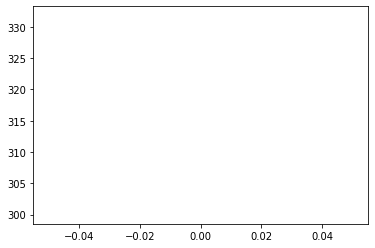

In [55]:
stop_step=int(4/0.002)
k_B=1.38064852*10**(-23)
dt=0.002
file_name='liquid256.txt'
position_init=np.loadtxt(file_name)
a_init=np.zeros((256,3))
r_c=2.5
L0=6.8

#cube division
subdiv=np.array([2,2,2])

energy_scale=1.66*10**(-21)#unit: J, Argon
sigma=3.4 #unit: Ang, Argon 
T_dimensional_equal=123#np.round(np.linspace(123,145,10))#unit K
T_equal=T_dimensional_equal*k_B/energy_scale
L_ls=256 #np.round(np.linspace(7.21578,7.69026,10),decimals=5)
# P_insta_m_ls=np.zeros((stop_step+1,1))
# T_insta_m_ls=np.zeros((stop_step+1,1))
# KE_m_ls=np.zeros((stop_step+1,1))
# PE_m_ls=np.zeros((stop_step+1,1))
#for ind, L0 in enumerate(L_ls):
ind=1
start_time=time.time()
L0=np.float(L0)
#print(L0)
info_test,PE_m_ls,KE_m_ls,T_insta_m_ls,P_insta_m_ls=LJ_MD(subdiv=subdiv,
                                                          position_init=position_init,
                                                          dt=dt,
                                                          stop_step=stop_step,
                                                          accel_init=a_init,
                                                          r_cut=r_c, 
                                                          L=L0,
                                                          T_eq=T_equal,#[ind],
                                                          e_scale=energy_scale,
                                                          sig=sigma)
#print('done')
end_time=time.time()
print("For this {} steps operation (dt={}) with r_cut = {} and L = {}, it took:".format(stop_step,dt,r_c_ls[1],L0),end_time-start_time,'s')

In [ ]:
print(info_test.shape)

NameError: ignored

In [ ]:
##TO DO
#actually add processors in velocity Verlet
#plot potential energy, debug
#figure out how to use numba for functions that have stuff that technically dont allow numba
#parallelize KE PE
#neighbor lists

##IF WE HAVE A LOT OF TIME
#modify algorithm not to look at diagonal regions


In [47]:
def cum_avg(arr=1):
    cum_sum = np.cumsum(arr, axis=0)    
    for i in range(cum_sum.shape[0]):       
        if i == 0:
            continue        
        cum_sum[i] =  cum_sum[i] / (i + 1)
    return cum_sum

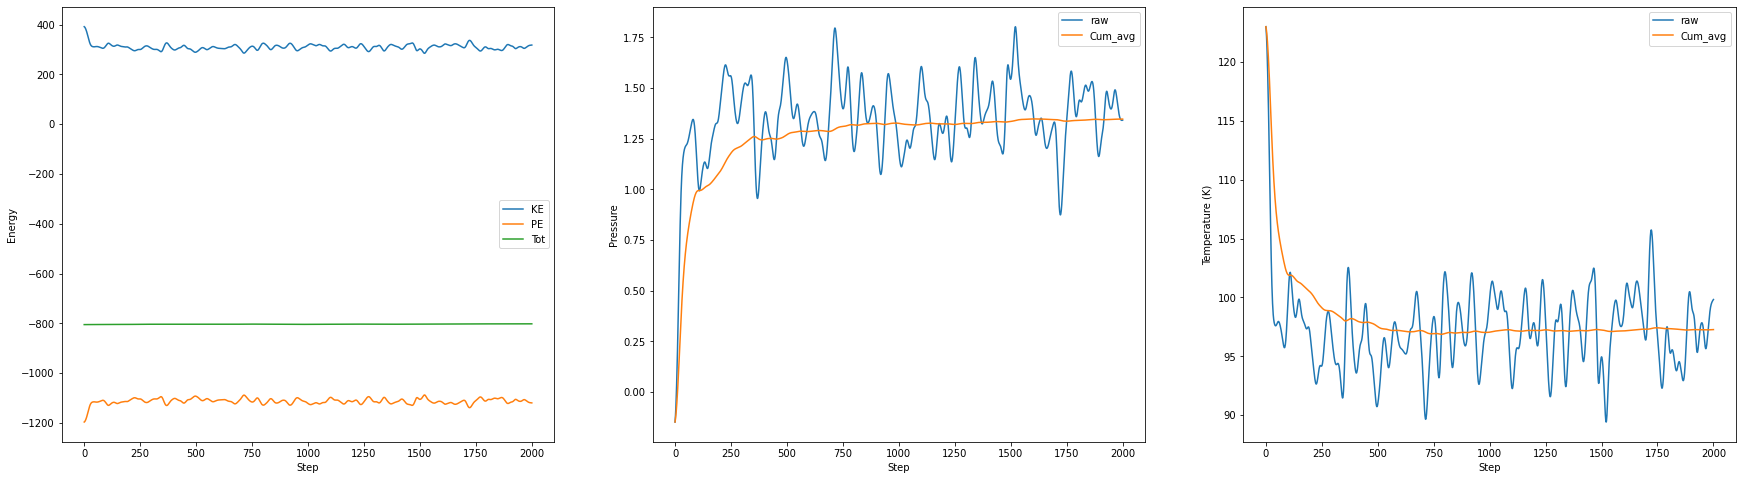

In [57]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(30,8))
ax[0].plot(KE_m_ls,label='KE')
ax[0].plot(PE_m_ls,label='PE')
ax[0].plot(PE_m_ls+KE_m_ls,label='Tot')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Energy')
ax[0].legend()
ax[1].plot(P_insta_m_ls,label='raw')
ax[1].plot(cum_avg(P_insta_m_ls),label='Cum_avg')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Pressure')
ax[1].legend()
ax[2].plot(T_insta_m_ls, label='raw')
ax[2].plot(cum_avg(T_insta_m_ls),label='Cum_avg')
ax[2].set_xlabel('Step')
ax[2].set_ylabel('Temperature (K)')
ax[2].legend()
# plt.plot(KE_m_ls[ind,1:1800,:])
# plt.plot(PE_m_ls[ind,1:1800,:])
# plt.plot()
# print(stop_step)
   

In [41]:
KE_m_ls[1,:,:].shape

(2001, 1)